Device: cpu
[Adam] Epoch 1/20 | Loss 0.452375 | ValAcc: 92.74%
[Adam] Epoch 2/20 | Loss 0.182338 | ValAcc: 95.29%
[Adam] Epoch 3/20 | Loss 0.119322 | ValAcc: 96.40%
[Adam] Epoch 4/20 | Loss 0.086200 | ValAcc: 96.48%
[Adam] Epoch 5/20 | Loss 0.064084 | ValAcc: 97.07%
[Adam] Epoch 6/20 | Loss 0.049802 | ValAcc: 97.00%
[Adam] Epoch 7/20 | Loss 0.037153 | ValAcc: 97.40%
[Adam] Epoch 8/20 | Loss 0.028104 | ValAcc: 97.62%
[Adam] Epoch 9/20 | Loss 0.024221 | ValAcc: 97.17%
[Adam] Epoch 10/20 | Loss 0.019566 | ValAcc: 97.38%
[Adam] Epoch 11/20 | Loss 0.012197 | ValAcc: 97.48%
[Adam] Epoch 12/20 | Loss 0.014492 | ValAcc: 97.14%
[Adam] Epoch 13/20 | Loss 0.010896 | ValAcc: 97.60%
[Adam] Epoch 14/20 | Loss 0.011314 | ValAcc: 97.24%
[Adam] Epoch 15/20 | Loss 0.010685 | ValAcc: 97.14%
[Adam] Epoch 16/20 | Loss 0.006460 | ValAcc: 97.71%
[Adam] Epoch 17/20 | Loss 0.008055 | ValAcc: 97.57%
[Adam] Epoch 18/20 | Loss 0.003856 | ValAcc: 97.50%
[Adam] Epoch 19/20 | Loss 0.003272 | ValAcc: 97.38%
[Adam] Ep

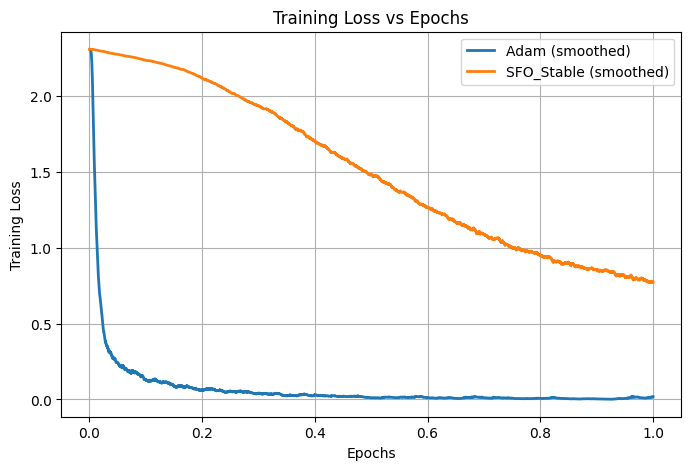

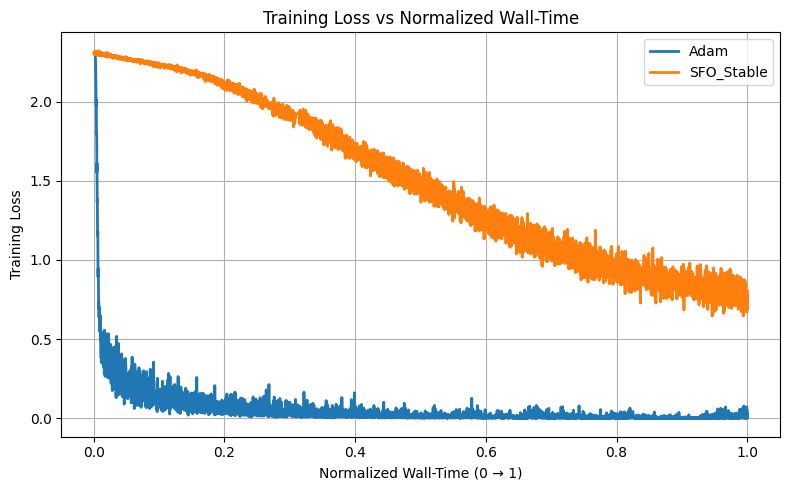

In [2]:
# Stable SFO optimizer + Adam baseline (Kaggle-ready)
# Includes: training loss vs epochs + training loss vs normalized walltime


def ema_smooth(data, alpha=0.05):
    smoothed = []
    s = data[0]
    for x in data:
        s = alpha * x + (1 - alpha) * s
        smoothed.append(s)
    return np.array(smoothed)

import os
import time                       # >>> ADDED FOR WALLTIME PLOT <<<
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import deque

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Load Kaggle MNIST CSV
# ---------------------------
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
y = train_df["label"].values
X = train_df.drop(columns=["label"]).values.astype(np.float32) / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# ---------------------------
# Dataset / DataLoader
# ---------------------------
class MNISTcsv(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

batch_size = 128
train_loader = DataLoader(MNISTcsv(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(MNISTcsv(X_val, y_val), batch_size=256, shuffle=False)

# ---------------------------
# Simple MLP
# ---------------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------
# Stable SFO Optimizer
# ---------------------------
class SFO_Stable(optim.Optimizer):
    def __init__(self, params, lr=5e-4, m=8, eps=1e-8, weight_decay=1e-6, clip=2.0, damping=1e-6, min_y_dot_s=1e-8):
        defaults = dict(lr=lr, m=m, eps=eps, weight_decay=weight_decay, clip=clip, damping=damping, min_y_dot_s=min_y_dot_s)
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state.setdefault('s_list', deque(maxlen=group['m']))
                state.setdefault('y_list', deque(maxlen=group['m']))
                state.setdefault('rho_list', deque(maxlen=group['m']))
                state.setdefault('prev_param', p.detach().clone())
                state.setdefault('prev_grad', torch.zeros_like(p.detach()))

    def _two_loop(self, p, g, state, group):
        s_list = list(state['s_list'])
        y_list = list(state['y_list'])
        rho_list = list(state['rho_list'])
        eps = group['eps']
        damping = group['damping']

        if len(s_list) == 0:
            denom = g.norm() + eps
            return g / denom

        q = g.clone()
        alphas = []
        for i in range(len(s_list)-1, -1, -1):
            s_i = s_list[i]
            y_i = y_list[i]
            rho_i = rho_list[i]
            alpha = rho_i * torch.dot(s_i.view(-1), q.view(-1))
            alphas.append(alpha)
            q = q - alpha * y_i

        s_last = s_list[-1]
        y_last = y_list[-1]
        sy = max(torch.dot(s_last.view(-1), y_last.view(-1)).item(), eps)
        yy = max(torch.dot(y_last.view(-1), y_last.view(-1)).item(), eps)
        H0 = sy / (yy + damping)
        r = H0 * q

        for i in range(len(s_list)):
            s_i = s_list[i]
            y_i = y_list[i]
            rho_i = rho_list[i]
            beta = rho_i * torch.dot(y_i.view(-1), r.view(-1))
            alpha = alphas[len(s_list)-1 - i]
            r = r + s_i * (alpha - beta)
        return r

    @torch.no_grad()
    def step(self):
        clip_val = self.param_groups[0]['clip']
        if clip_val is not None:
            params_all = []
            for g in self.param_groups:
                params_all.extend(g['params'])
            torch.nn.utils.clip_grad_norm_(params_all, clip_val)

        for group in self.param_groups:
            lr = group['lr']
            wd = group['weight_decay']
            min_y_dot_s = group['min_y_dot_s']

            for p in group['params']:
                if p.grad is None:
                    continue

                g = p.grad.detach().clone()
                state = self.state[p]

                prev_param = state['prev_param']
                prev_grad = state['prev_grad']

                s_candidate = p.detach() - prev_param
                y_candidate = g - prev_grad

                y_dot_s = torch.dot(y_candidate.view(-1), s_candidate.view(-1)).item()
                if y_dot_s > min_y_dot_s:
                    rho = 1.0 / (y_dot_s + 1e-16)
                    state['s_list'].append(s_candidate.clone())
                    state['y_list'].append(y_candidate.clone())
                    state['rho_list'].append(rho)

                try:
                    dir_vec = self._two_loop(p, g, state, group)
                except:
                    dir_vec = g / (g.norm() + group['eps'])

                if wd != 0:
                    p.mul_(1 - wd * lr)

                p.add_(dir_vec, alpha=-lr)

                state['prev_param'] = p.detach().clone()
                state['prev_grad'] = g.clone()

# ---------------------------
# Evaluation
# ---------------------------
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return 100.0 * correct / total

# ---------------------------
# Training + walltime tracking
# ---------------------------
def train_compare(epochs=20):
    model_adam = MLP().to(device)
    model_sfo = MLP().to(device)

    adam_opt = optim.Adam(model_adam.parameters(), lr=1e-3, weight_decay=1e-6)
    sfo_opt  = SFO_Stable(model_sfo.parameters(), lr=5e-4, m=8, weight_decay=1e-6)

    criterion = nn.CrossEntropyLoss()

    adam_epoch_losses = []
    sfo_epoch_losses  = []

    # >>> ADDED FOR WALLTIME PLOT <<<
    adam_times = []
    sfo_times  = []
    adam_loss_wall = []
    sfo_loss_wall  = []
    start = time.time()
    # -----------------------------------

    # Train Adam
    t0 = time.time()
    for epoch in range(epochs):
        model_adam.train()
        total_loss = 0.0
        count = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            adam_opt.zero_grad()
            out = model_adam(Xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_adam.parameters(), 2.0)
            adam_opt.step()

            total_loss += loss.item()
            count += 1

            # >>> ADDED: track time & loss
            t_now = time.time() - t0
            adam_times.append(t_now)
            adam_loss_wall.append(loss.item())

        epoch_loss = total_loss / count
        adam_epoch_losses.append(epoch_loss)
        print(f"[Adam] Epoch {epoch+1}/{epochs} | Loss {epoch_loss:.6f} | ValAcc: {evaluate_model(model_adam):.2f}%")

    # Train SFO_Stable
    t0 = time.time()
    for epoch in range(epochs):
        model_sfo.train()
        total_loss = 0.0
        count = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            model_sfo.zero_grad()
            out = model_sfo(Xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_sfo.parameters(), 2.0)
            sfo_opt.step()

            total_loss += loss.item()
            count += 1

            # >>> ADDED: time & loss tracking
            t_now = time.time() - t0
            sfo_times.append(t_now)
            sfo_loss_wall.append(loss.item())

        epoch_loss = total_loss / count
        sfo_epoch_losses.append(epoch_loss)
        print(f"[SFO_Stable] Epoch {epoch+1}/{epochs} | Loss {epoch_loss:.6f} | ValAcc: {evaluate_model(model_sfo):.2f}%")

    # save models
    torch.save(model_adam.state_dict(), "/kaggle/working/model_adam_stable.pth")
    torch.save(model_sfo.state_dict(), "/kaggle/working/model_sfo_stable.pth")

    return adam_epoch_losses, sfo_epoch_losses, adam_times, sfo_times, adam_loss_wall, sfo_loss_wall

# ---------------------------
# Run training
# ---------------------------
epochs = 20
adam_losses, sfo_losses, adam_times, sfo_times, adam_lw, sfo_lw = train_compare(epochs)

# ---------------------------
# Normalize times for plotting
# ---------------------------
import numpy as np
adam_times = np.array(adam_times)
sfo_times  = np.array(sfo_times)

adam_norm_t = adam_times / adam_times[-1]
sfo_norm_t  = sfo_times  / sfo_times[-1]

# ---------------------------
# Plot 1: Training loss vs epochs
# ---------------------------
ep = list(range(1, epochs+1))

plt.figure(figsize=(8,5))
# Smooth curves (lower alpha = smoother)
adam_smooth = ema_smooth(adam_lw, alpha=0.03)
sfo_smooth  = ema_smooth(sfo_lw,  alpha=0.03)

plt.plot(adam_norm_t, adam_smooth, label="Adam (smoothed)", linewidth=2)
plt.plot(sfo_norm_t,  sfo_smooth,  label="SFO_Stable (smoothed)", linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.show()

# ---------------------------
# >>> NEW PLOT: Training Loss vs Normalized Wall-Time <<<
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(adam_norm_t, adam_lw, label="Adam", linewidth=2)
plt.plot(sfo_norm_t,  sfo_lw, label="SFO_Stable", linewidth=2)
plt.xlabel("Normalized Wall-Time (0 → 1)")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Normalized Wall-Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


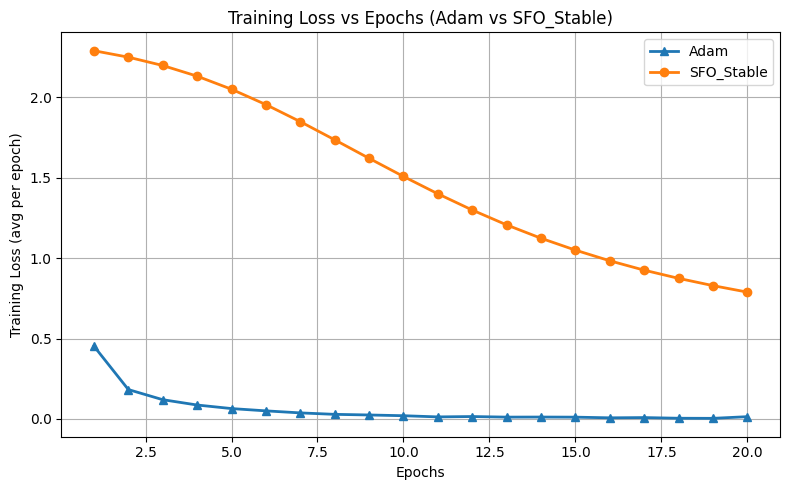

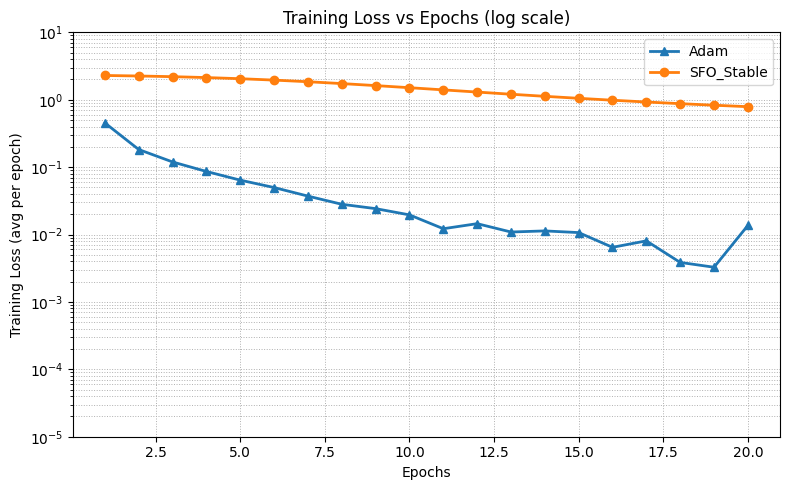

Saved plot to: /kaggle/working/training_loss_adam_vs_sfo_stable.png
Reference image (uploaded earlier): /mnt/data/d2f88e95-1b22-4106-bf4a-c9d5bf3db1bc.png


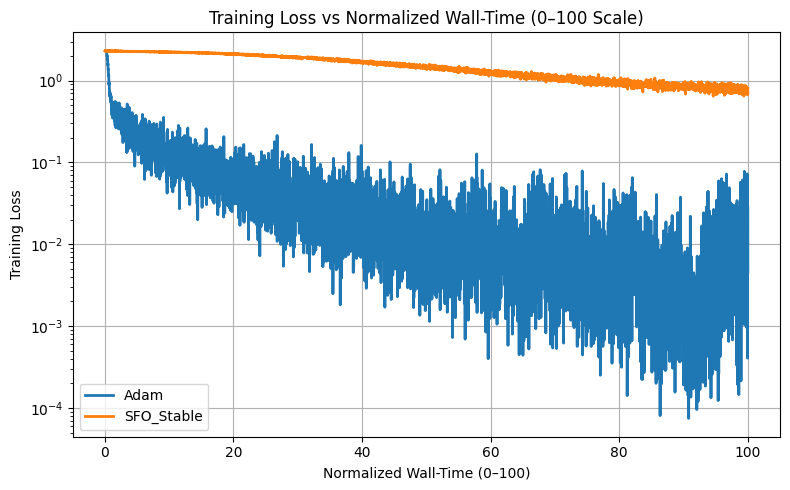

In [3]:


# Plot Training Loss vs Epochs (linear + log)
ep = list(range(1, epochs+1))

plt.figure(figsize=(8,5))
plt.plot(ep, adam_losses, marker='^', label='Adam', linewidth=2)
plt.plot(ep, sfo_losses, marker='o', label='SFO_Stable', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Training Loss (avg per epoch)")
# plt.yscale("log")
plt.title("Training Loss vs Epochs (Adam vs SFO_Stable)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Paper-style log plot
plt.figure(figsize=(8,5))
plt.plot(ep, adam_losses, marker='^', label='Adam', linewidth=2)
plt.plot(ep, sfo_losses, marker='o', label='SFO_Stable', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Training Loss (avg per epoch)")
plt.ylim(0.00001,10)
plt.title("Training Loss vs Epochs (log scale)")
plt.yscale("log")

plt.grid(True, which='both', linestyle=':', linewidth=0.7)
plt.legend()
plt.tight_layout()
save_path = "/kaggle/working/training_loss_adam_vs_sfo_stable.png"
plt.savefig(save_path)
plt.show()

print("Saved plot to:", save_path)
print("Reference image (uploaded earlier): /mnt/data/d2f88e95-1b22-4106-bf4a-c9d5bf3db1bc.png")


# ---------------------------
# Normalize times to 0–100
# ---------------------------
adam_norm_t = 100 * (adam_times / adam_times[-1])
sfo_norm_t  = 100 * (sfo_times  / sfo_times[-1])

# ---------------------------
# UPDATED PLOT: Loss vs 0–100 scaled wall-time
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(adam_norm_t, adam_lw, label="Adam", linewidth=2)
plt.plot(sfo_norm_t,  sfo_lw, label="SFO_Stable", linewidth=2)
plt.xlabel("Normalized Wall-Time (0–100)")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Normalized Wall-Time (0–100 Scale)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

